##  DATA SET CREATION  

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os

# Custom dataset class
class RoadDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Assume we have lists of file paths for images and masks
train_image_paths = ["/kaggle/input/data-road-train/dataset/train_orig"]
train_mask_paths = ["/kaggle/input/data-road-train/dataset/train_masked"]

# Create dataset and dataloader
train_dataset = RoadDataset(train_image_paths, train_mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)


## TRAINING

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
from tqdm import tqdm

# Define custom dataset
class RoadDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('RGB')
        mask = Image.open(self.mask_paths[idx]).convert('L')
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

# Load image and mask file paths
train_image_dir = '/kaggle/input/data-road-train/dataset/train_orig'
train_mask_dir = '/kaggle/input/data-road-train/dataset/train_masked'
train_image_paths = sorted(glob(os.path.join(train_image_dir, '*.jpg')))
train_mask_paths = sorted(glob(os.path.join(train_mask_dir, '*.png')))

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Create dataset and dataloader
train_dataset = RoadDataset(train_image_paths, train_mask_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)

# Load the pretrained DeepLabV3 model
model = deeplabv3_resnet50(pretrained=True)

# Modify the classifier to match the number of classes in the dataset (assuming binary classification: road vs non-road)
model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))

# Move the model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(train_loader):
        images = images.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')

# Save the trained model
torch.save(model.state_dict(), 'road_detection_model.pth')


## LOADING THE TRAINED MODEL

In [7]:
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50

def load_deeplabv3_model():
    model = deeplabv3_resnet50(pretrained=False)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

# Load the modified model
model = load_deeplabv3_model()

# Load model weights with filtered state dictionary
def load_model_weights(model, model_path, device):
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

# Determine the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = 'road_detection_model.pth'
load_model_weights(model, model_path, device)

# Move the model to the device
model = model.to(device)
model.eval()  # Set the model to evaluation mode


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

## TEST DATA  AND MODEL LOADING FOR PREDICTIONS

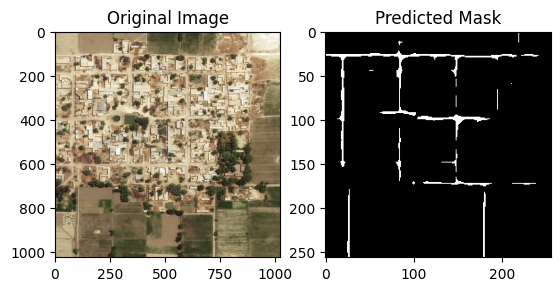

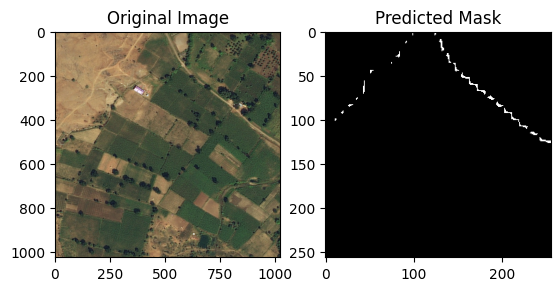

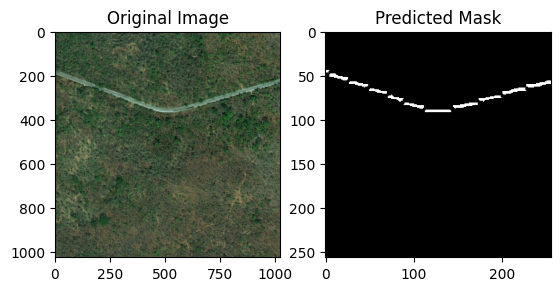

In [18]:
import os
from glob import glob
import torch
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Define transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

# Define test dataset
class TestDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_path = image_path.replace('\\', '/')  # Replace backslashes with forward slashes
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, image_path

# Prepare test data
test_image_dir = 'dataset/test'  # Update this path
test_image_paths = sorted(glob(os.path.join(test_image_dir, '*.jpg')))

# Replace backslashes with forward slashes
test_image_paths = [path.replace('\\', '/') for path in test_image_paths]

test_image_paths=test_image_paths[0:3]
# Create test dataset and dataloader
test_dataset = TestDataset(test_image_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

# Load the modified model
def load_deeplabv3_model():
    model = deeplabv3_resnet50(pretrained=False)
    model.classifier[4] = nn.Conv2d(256, 1, kernel_size=(1, 1), stride=(1, 1))
    return model

model = load_deeplabv3_model()

# Load model weights with filtered state dictionary
def load_model_weights(model, model_path, device):
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=False)

# # Determine the device (GPU if available, otherwise CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_path = 'road_detection_model.pth'
load_model_weights(model, model_path, device)

# Move the model to the device
model = model.to(device)
model.eval()

# Run predictions
def predict(model, dataloader, device):
    model.eval()
    predictions = []
    with torch.no_grad():
        for images, image_paths in dataloader:
            images = images.to(device)
            outputs = model(images)['out']
            preds = torch.sigmoid(outputs).cpu().numpy()
            preds = preds > 0.5  # Threshold the predictions
            predictions.extend(zip(image_paths, preds))
    return predictions

predictions = predict(model, test_loader, device)

# Save the predictions in the specified folder
output_dir = 'dataset/predictions'  # Update this path
os.makedirs(output_dir, exist_ok=True)

for image_path, pred in predictions:
    pred_image = pred.squeeze(0)  # Remove the batch dimension
    pred_image = (pred_image * 255).astype(np.uint8)  # Convert to uint8
    pred_image = Image.fromarray(pred_image)
    output_path = os.path.join(output_dir, os.path.basename(image_path))
    pred_image.save(output_path)

    # Optional: Display the prediction
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(Image.open(image_path))
    plt.subplot(1, 2, 2)
    plt.title("Predicted Mask")
    plt.imshow(pred_image, cmap='gray')
    plt.show()
    

In [16]:
test_image_paths

['dataset/test/100393_sat.jpg',
 'dataset/test/100995_sat.jpg',
 'dataset/test/101982_sat.jpg']